In [130]:
'''@author: chensong
   @date: 2025-12-06 15:28:11
   @lasteditors: chensong
   @lastedittime: 2025-12-06 15:28:11
   @file_path: /  
   @description:      经典识别MNIST手写数字识别
'''
import torch; # 引入torch库
from torch import nn; # 从torch库中引入神经网络模块
from torch.utils.data import DataLoader; # 引入数据加载和数据集模块
from torchvision import datasets; # 引入图像转换模块
from torchvision.transforms import ToTensor; # 引入将图像转换为张量的模块


In [131]:
#引入训练数据集

import test


train_data = datasets.MNIST(
    root="./data", # 数据集存放路径
    train=True, # 指定为训练集
    download=True, # 如果数据集不存在则下载
    transform=ToTensor() # 将图像转换为张量    
) 

#引入测试数据集
test_data = datasets.MNIST(
    root="./data", # 数据集存放路径 
    train=False, # 指定为测试集
    download=True, # 如果数据集不存在则下载
    transform=ToTensor() # 将图像转换为张量
)




# 二、 加载数据


In [142]:
# 设置梯度下降的参数
batch_size = 64; # 每个批次的样本数量

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True); # 创建训练数据加载器
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True); # 创建测试数据加载器

for X, y in train_dataloader: # 遍历测试数据加载器
    #   torch.Size([64, 1, 28, 28]) ==>  64个样本,1个通道,28x28像素
    print("Shape of X [N, C, H, W]: ", X.shape); # 打印输入数据的形状
    # torch.Size([64]) torch.int64  ==> 64个标签,数据类型为int64
    print("Shape of y: ", y.shape, y.dtype); # 打印标签的形状和数据类型
    break; # 只查看第一个批次的数据

for X, y in test_dataloader: # 遍历测试数据加载器
    print("Shape of X [N, C, H, W]: ", X.shape); # 打印输入数据的形状
    print("Shape of y: ", y.shape, y.dtype); # 打印标签的形状和数据类型
    break; # 只查看第一个批次的数据



Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


# 三、 构建神经网络

1. 定义神经网络类， 并继承自nn.Module
2. Pytorch使用nn.Sequential对象创建神经网络
3. 神经网络类中必须实现forward()方法
4. Pytorch使用nn.Flatten 对象将图片转中列向量
5. nn.to方法可以让模型运行在不同的硬件上


Pytorch中有默认反向传播的函数


In [143]:
from zmq import device


device = "cuda" if torch.cuda.is_available() else "cpu"; # 检查是否有可用的GPU,否则使用CPU
print("Using {} device".format(device)); # 打印使用的设备类型

 

# 构建神经网络类  
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__(); # 调用父类的构造函数
        self.flatten = nn.Flatten(); # 定义一个展平层
        self.linear_relu_stack = nn.Sequential( # 定义一个顺序容器
            nn.Linear(28*28, 128), # 全连接层,输入大小为28*28,输出大小为128
            nn.BatchNorm1d(128), # 批归一化层,输入大小为128
            nn.ReLU(), # ReLU激活函数
            nn.Dropout(0.2), # Dropout层,丢弃率为0.2
            nn.Linear(128, 512), # 全连接层,输入大小为512,输出大小为128
            nn.BatchNorm1d(512), # 批归一化层,输入大小为512
            nn.ReLU(), # ReLU激活函数
            nn.Dropout(0.2), # Dropout层,丢弃率为0.2    
            
            nn.Linear(512, 128), # 全连接层,输入大小为128,输出大小为128
            nn.ReLU(), # ReLU激活函数
            nn.Linear(128, 10) # 全连接层,输入大小为128,输出大小为10
        );

    def forward(self, x):
        x = self.flatten(x); # 展平输入数据
        logits = self.linear_relu_stack(x); # 通过顺序容器进行前向传播
        return logits; # 返回输出结果
# 创建神经网络实例并移动到指定设备
model = NeuralNetwork().to(device);
print(model); # 打印神经网络结构



Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


# 四、Pytorch训练神经网络的步骤

1. 指定model工作模式： train/eval
2. 循环读取小批量数据
3. 进行训练（前向传播）
4. 通过损失函数计算损失
5. 反向传播， 计算梯度
6. 更新梯度
7. 清空本次小批量梯度， 确保每次小批量都重新技术梯度




# 五、 Pytorch中损失函数

1. 回归相关：nn.MSELoss(均方差)、nn.L1Loss(平均绝对差)
2. 多分类： nn.CrossEntropyLoss包含了softmax

nn.NULLLoss需要手动添加softmax的函数

# 六、优化器

1. SGD： 随机梯度下降
2. Adam： 最佳优化器
3. RMSprop


In [144]:
#定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss(); # 交叉熵损失函数,适用于多分类问题
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3); # 随机梯度下降优化器,学习率为0.001

# 训练神经网络tran
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset); # 获取数据集的大小
    model.train(); # 设置模型为训练模式
    train_loss, train_correct = 0, 0; # 初始化测试损失和正确预测数量
    for batch, (X, y) in enumerate(dataloader): # 遍历数据加载器
        X, y = X.to(device), y.to(device); # 将数据和标签移动到指定设备

        # 计算预测误差
        pred = model(X); # 通过模型进行前向传播
        loss = loss_fn(pred, y); # 计算损失

        # 反向传播
        optimizer.zero_grad(); # 清除梯度
        loss.backward(); # 反向传播计算梯度
        optimizer.step(); # 更新模型参数
        train_loss += loss.item(); # 累加损失
        _, predicted = torch.max(pred, 1); # 获取预测结果
        train_correct += (predicted == y).sum().item(); # 计算正确预测数量

        if batch % 100 == 0: # 每100个批次打印一次日志
            loss, current = loss.item(), batch * len(X); # 获取当前损失和处理的数据量
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]"); # 打印损失和进度信息
    avg_loss = train_loss / size; # 计算平均损失
    avg_accuracy = train_correct / size; # 计算平均准确率
    print(f"Train Error: \n Accuracy: {(100*avg_accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n"); # 打印训练误差信息


# 七、Pytorh神经网络评估的步骤

1. 指定model工作模式： eval
2. 禁止梯度计算与跟踪， 因为在测试阶段不需要计算梯度
3. 进行预测（前向传播）
4. 通过损失函数计算损失

In [145]:

# 测试神经网络
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset); # 获取数据集的大小
    num_batches = len(dataloader); # 获取批次数量
    model.eval(); # 设置模型为评估模式
    test_loss, correct = 0, 0; # 初始化测试损失和正确预测数量
    with torch.no_grad(): # 禁用梯度计算
        for X, y in dataloader: # 遍历数据加载器
            X, y = X.to(device), y.to(device); # 将数据和标签移动到指定GPU设备
            pred = model(X); # 通过模型进行前向传播
            test_loss += loss_fn(pred, y).item(); # 累加损失
            correct += (pred.argmax(1) == y).type(torch.float).sum().item(); # 计算正确预测数量
    test_loss /= num_batches; # 计算平均损失
    correct /= size; # 计算准确率
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"); # 打印测试结果 
# 运行训练和测试循环
epochs = 5; # 设置训练轮数
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------");
    train(train_dataloader, model, loss_fn, optimizer); # 训练模型
    test(test_dataloader, model, loss_fn); # 测试模型
print("Done!");


Epoch 1
-------------------------------
loss: 2.325360  [    0/60000]
loss: 0.330338  [ 6400/60000]
loss: 0.369455  [12800/60000]
loss: 0.284601  [19200/60000]
loss: 0.211268  [25600/60000]
loss: 0.537628  [32000/60000]
loss: 0.139032  [38400/60000]
loss: 0.153619  [44800/60000]
loss: 0.129348  [51200/60000]
loss: 0.271651  [57600/60000]
Train Error: 
 Accuracy: 91.7%, Avg loss: 0.004288 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.110016 

Epoch 2
-------------------------------
loss: 0.179400  [    0/60000]
loss: 0.170453  [ 6400/60000]
loss: 0.088300  [12800/60000]
loss: 0.198921  [19200/60000]
loss: 0.095784  [25600/60000]
loss: 0.109512  [32000/60000]
loss: 0.119613  [38400/60000]
loss: 0.189058  [44800/60000]
loss: 0.084392  [51200/60000]
loss: 0.158331  [57600/60000]
Train Error: 
 Accuracy: 95.5%, Avg loss: 0.002266 

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.088678 

Epoch 3
-------------------------------
loss: 0.043778  [    0/60000]
loss: 0.151061  [ 6400/60000]
loss: 0.11

# 八、模型保存


In [146]:
# 模型保存
torch.save(model.state_dict(), "model_weights.pth"); # 保存模型参数到文件
print("Saved PyTorch Model State to model_weights.pth");


Saved PyTorch Model State to model_weights.pth


# 9、加载模型


In [147]:
# 载入模型参数
model = NeuralNetwork().to(device);
model.load_state_dict(torch.load("model_weights.pth", weights_only=True) ); # 从文件加载模型参数
print("Loaded PyTorch Model State from model_weights.pth"); 



Loaded PyTorch Model State from model_weights.pth


In [148]:

# 预测结果
model.eval(); # 设置模型为评估模式
x, y = test_data[0][0], test_data[0][1]; # 获取测试数据的第一个样本和标签
with torch.no_grad(): # 禁用梯度计算
    pred = model(x); # 通过模型进行前向传播
    predicted, actual = pred[0].argmax(0), y; # 获取预测结果和实际标签
    print(f"Predicted: {predicted}, Actual: {actual}"); # 打印预测结果和实际标签
    

Predicted: 7, Actual: 7


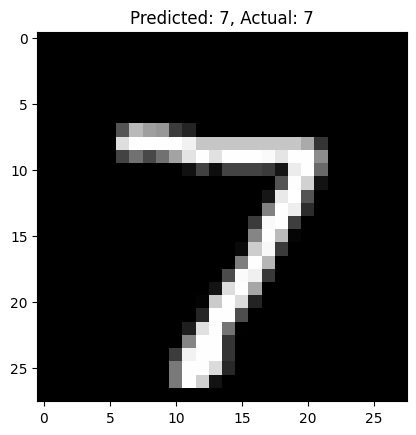

In [ ]:
# 打印 mathplotlib 版本
import matplotlib.pyplot as plt;
# print(f"matplotlib version: {plt.__version__}");

plt.imshow(x.cpu().squeeze(), cmap="gray"); # 显示图像
plt.title(f"Predicted: {predicted}, Actual: {actual}"); # 设置
plt.show(); # 显示图形
